# Лабораторная работа №2
Используя явную схему крест и неявную схему, решить начально-краевую задачу для дифференциального уравнения гиперболического типа. Аппроксимацию второго начального условия произвести с первым и со вторым порядком. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x, t)$. Исследовать зависимость погрешности от сеточных параметров $\tau, h$.   
Дифференциальное уравнение:   
$\frac{\partial^{2} u}{\partial t^{2}}+2 \frac{\partial u}{\partial t}=\frac{\partial^{2} u}{\partial x^{2}}+2 \frac{\partial u}{\partial x}-3 u$,   
$u(0, t)=\exp (-t) \cos (2 t)$,   
$u\left(\frac{\pi}{2}, t\right)=0$,   
$u(x, 0)=\exp (-x) \cos x$,   
$u_t(x, 0)=-\exp (-x) \cos x$.   
Аналитическое решение: $U(x, t)=\exp (-t-x) \cos x \cos (2 t)$.

In [1]:
import numpy as np

args = {
    'aConst': 1,
    'bConst': 2,
    'cConst': -3,
    'dConst': 2,
    'l': np.pi / 2,
    'Function': lambda: 0,
    'alpha': 1,
    'beta': 0,
    'gamma': 1,
    'delta': 0,
    'Psi1': lambda x: np.exp(-x) * np.cos(x),
    'Psi2': lambda x: -np.exp(-x) * np.cos(x),
    'Psi11': lambda x: -np.exp(-x) * np.sin(x) - np.exp(-x) * np.cos(x),
    'Psi12': lambda x:  2 * np.exp(-x) * np.sin(x),
    'Phi0': lambda t: np.exp(-t) * np.cos(2 * t),
    'PhiL': lambda t: 0,
    'type': '1-2',
    'accuracyLevl': 1,
    'AnaliticalSolution': lambda x, t: np.exp(-t - x) * np.cos(x) * np.cos(2 * t),
    'algorithm': 'Implicit'
}

In [2]:
class HyperbolicSolver:
    def __init__(self, args):
        for name, value in args.items():
            setattr(self, name, value)
        first = args['algorithm'][0].upper()
        word = args['algorithm'][1:].lower()
        functionName = first + word
        try:
            self.FunctionName = getattr(self, functionName)
        except:
            raise Exception("Данный тип не поддерживается, выберите Implicit или Explicit")

    def Solve(self, N, K, T):
        self.h = self.l/ N;
        self.tau = T / K;
        self.sigma = (self.tau ** 2) / (self.h ** 2)
        return self.FunctionName(N, K, T)

    def AnaliticalSolutionMatrix(self, N, K, T):
        self.h = self.l / N;
        self.tau = T / K;
        self.sigma = (self.tau ** 2) / (self.h ** 2)
        self.u = np.zeros((K, N))
        for k in range(K):
            for j in range(N):
                self.u[k][j] = self.AnaliticalSolution(j * self.h, k * self.tau)
        return self.u

    def RunThroughMethod(self):
        size = len(self.a)
        p = np.zeros(size)
        q = np.zeros(size)
        p[0] = (-self.c[0] / self.b[0])
        q[0] = (self.d[0] / self.b[0])

        for i in range(1, size):
            p[i] = -self.c[i] / (self.b[i] + self.a[i] * p[i - 1])
            q[i] = (self.d[i] - self.a[i] * q[i - 1]) / (self.b[i] + self.a[i] * p[i - 1])

        x = np.zeros(size)
        x[-1] = q[-1]

        for i in range(size - 2, -1, -1):
            x[i] = p[i] * x[i + 1] + q[i]

        return x

    def Implicit(self, N, K, T):
        self.u = np.zeros((K, N))
        for j in range(N):
            xCurrent = j * self.h
            self.u[0][j] = self.Psi1(xCurrent)
            if self.accuracyLevl == 1:
                self.u[1][j] = self.Psi1(xCurrent) + self.Psi2(xCurrent) * self.tau + self.Psi12(xCurrent) * self.tau ** 2 / 2
            elif self.accuracyLevl == 2:
                k = self.tau ** 2 / 2
                self.u[1][j] = (1 + self.cConst * k) * self.Psi2(xCurrent) + self.aConst * k * self.Psi12(xCurrent) + self.bConst * k * self.Psi11(xCurrent) + (self.tau - self.dConst * k) * self.Psi1(xCurrent) + k * self.Function()

        self.a = np.zeros(N)
        self.b = np.zeros(N)
        self.c = np.zeros(N)
        self.d = np.zeros(N)
        for k in range(2, K):
            for j in range(1, N - 1):
                self.a[j] = self.sigma
                self.b[j] = -(1 + 2 * self.sigma)
                self.c[j] = self.sigma
                self.d[j] = -2 * self.u[k - 1][j] + self.u[k - 2][j]

            if self.type == '1-2':
                self.b[0] = self.alpha / self.h / (self.beta - self.alpha / self.h)
                self.c[0] = 1
                self.d[0] = 1 / (self.beta - self.alpha / self.h) * self.Phi0(k * self.tau)
                self.a[-1] = -self.gamma / self.h / (self.delta + self.gamma / self.h)
                self.d[-1] = 1 / (self.delta + self.gamma / self.h) * self.PhiL(k * self.tau)

            elif self.type == '2-2':
                self.b[0] = 2 * self.aConst / self.h
                self.c[0] = -2 * self.aConst / self.h + self.h / self.tau ** 2 - self.cConst * self.h + -self.dConst * self.h / (2 * self.tau) + self.beta / self.alpha * (2 * self.aConst + self.bConst * self.h)
                self.d[0] = self.h / self.tau ** 2 * (self.u[k - 2][0] - 2 * self.u[k - 1][0]) - self.h * self.Function() + -self.dConst * self.h / (2 * self.tau) * self.u[k - 2][0] + (2 * self.aConst - self.bConst * self.h) / self.alpha * self.Phi0(k * self.tau)
                self.a[-1] =-self.b[0]
                self.d[-1] = self.h / self.tau ** 2 * (-self.u[k - 2][0] + 2 * self.u[k - 1][0]) + self.h * self.Function() + self.dConst * self.h / (2 * self.tau) * self.u[k - 2][0] + (2 * self.aConst + self.bConst * self.h) / self.alpha * self.PhiL(k * self.tau)

            elif self.type == '2-3':
                k1 = 2 * self.h * self.beta - 3 * self.alpha
                k2 = 2 * self.h * self.delt + 3 * self.gamma
                omega = self.tau ** 2 * self.bConst / (2 * self.h)
                xi = self.dConst * self.tau / 2
                self.b[0] = 4 * self.alpha - self.alpha / (self.sigma + omega) * (1 + xi + 2 * self.sigma - self.cConst * self.tau ** 2)
                self.c[0] = k1 - self.alpha * (omega - self.sigma) / (omega + self.sigma)
                self.d[0] = 2 * self.h * self.Phi0(k * self.tau) + self.alpha * self.d[1] / (-sigma - omega)
                self.a[-1] = -self.gamma / (omega - sel.sigma) * (1 + xi + 2 * self.sigma - self.cConst * self.tau ** 2) - 4 * self.gamma
                self.d[-1] = 2 * self.h * self.PhiL(k * self.tau) - self.gamma * self.d[-2] / (omega - self.sigma)

            self.u[k] = self.RunThroughMethod()

        return self.u

    def Explicit(self, N, K, T):
        self.u = np.zeros((K, N))
        for j in range(N):
            xCurrent = j * self.h
            self.u[0][j] = self.Psi1(xCurrent)
            if self.accuracyLevl == 1:
                self.u[1][j] = self.Psi1(xCurrent) + self.Psi2(xCurrent) * self.tau + self.Psi12(xCurrent) * self.tau ** 2 / 2
            elif self.accuracyLevl == 2:
                k = self.tau ** 2 / 2
                self.u[1][j] = (1 + self.cConst * k) * self.Psi2(xCurrent) + self.aConst * k * self.Psi12(xCurrent) + self.bConst * k * self.Psi11(xCurrent) + (self.tau - self.dConst * k) * self.Psi1(xCurrent) + k * self.Function()

        if self.type == '1-2':
            LBound = self.LBound12
            RBound = self.RBound12
        elif self.type == '2-2':
            LBound = self.LBound22
            RBound = self.RBound22
        elif self.type == '2-3':
            LBound = self.LBound23
            RBound = self.RBound23
        for k in range(2, K):
            t = k * self.tau
            for j in range(1, N - 1):
                self.u[k][j] = self.u[k - 1][j + 1] * (self.sigma + self.bConst * self.tau ** 2 / (2 * self.h)) + self.u[k - 1][j] * (-2 * self.sigma + 2 + self.cConst * self.tau ** 2) + self.u[k - 1][j - 1] * (self.sigma - self.bConst * self.tau ** 2 / (2 * self.h)) - self.u[k - 2][j] + self.tau ** 2 * self.Function()

            self.u[k][0] = LBound(k, t)
            self.u[k][-1] = RBound(k, t)

        return self.u

    def LBound12(self, k, t):
        return -(self.alpha / self.h) / (self.beta - self.alpha / self.h) * self.u[k - 1][1] + self.Phi0(t) / (self.beta - self.alpha / self.h)

    def RBound12(self, k, t):
        return (self.gamma / self.h) / (self.delta + self.gamma / self.h) * self.u[k - 1][-2] + self.PhiL(t) / (self.delta + self.gamma / self.h)

    def LBound22(self, k, t):
        n = self.cConst * self.h - 2 * self.aConst / self.h - self.h / self.tau ** 2 - self.dConst * self.h / (2 * self.tau) + self.beta / self.alpha * (2 * self.aConst - self.bConst * self.h)
        return 1 / n * (- 2 * self.aConst / self.h * self.u[k][1] + self.h / self.tau ** 2 * (self.u[k - 2][0] - 2 * self.u[k - 1][0]) + -self.dConst * self.h / (2 * self.tau) * self.u[k - 2][0] + -self.h * self.Function() + (2 * self.aConst - self.bConst * self.h) / self.alpha * self.Phi0(t))

    def RBound22(self, k, t):
        n = -self.cConst * self.h + 2 * self.aConst / self.h + self.h / self.tau ** 2 + self.dConst * self.h / (2 * self.tau) + self.delta / self.gamma * (2 * self.aConst + self.bConst * self.h)
        return 1 / n * (2 * self.aConst / self.h * self.u[k][-2] + self.h / self.tau ** 2 * (2 * self.u[k - 1][-1] - self.u[k - 2][-1]) + self.dConst * self.h / (2 * self.tau) * self.u[k - 2][-1] + self.h * self.Function() + (2 * self.aConst + self.bConst * self.h) / self.gamma * self.PhiL(t))

    def LBound23(self, k, t):
        n = 2 * self.h * self.beta - 3 * self.alpha
        return self.alpha / n * self.u[k - 1][2] - 4 * self.alpha / n * self.u[k - 1][1] + 2 * self.h / n * self.Phi0(t)

    def RBound23(self, k, t):
        n = 2 * self.h * self.delta + 3 * self.gamma
        return 4 * self.gamma / n * self.u[k - 1][-2] - self.gamma / n * self.u[k - 1][-3] + 2 * self.h / n * self.PhiL(t)

In [3]:
algorithms = ('Explicit', 'Implicit')
T, K, N = 70, 750, 15
read = input('Задать значения руками?\n')
if 'да' in read.lower():
    T = int(input('T = '))
    K = int(input('K = '))
    N = int(input('N = '))
    
answers = dict()
solver = HyperbolicSolver(args)
analytic = solver.AnaliticalSolutionMatrix(N, K, T)
answers['Analytic'] = analytic
for algorithm in algorithms:
    args['algorithm'] = algorithm
    solver = HyperbolicSolver(args)
    numeric = solver.Solve(N, K, T)
    answers[algorithm] = numeric

Задать значения руками?
нет


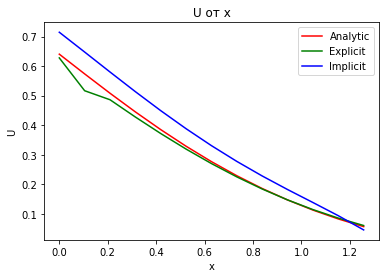

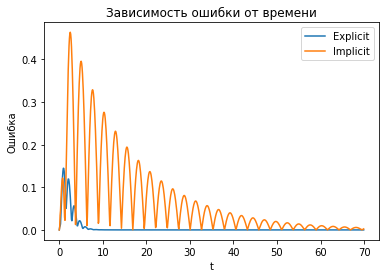

In [4]:
import matplotlib.pyplot as plt

def GetError(numeric, analytic):
    err = []
    error = [[abs(i - j) for i, j in zip(x, y)] for x, y in zip(numeric, analytic)]
    for i in range(len(error)):
        tmp = 0
        for j in error[i]:
            tmp += j
        err.append(tmp / len(error[i]))
    return err

def Draw2DCharts(answers, N, K, T, time=3):
    fig = plt.figure()
    x = np.arange(0, np.pi / 2, np.pi / 2 / N)
    t = np.arange(0, T, T / K)
    z1 = np.array(answers['Analytic'])
    z2 = np.array(answers['Explicit'])
    z3 = np.array(answers['Implicit'])

#     print(z1)

    plt.title('U от x')
    plt.plot(x[0:-2], z1[time][0:-2], color='r', label='Analytic')
    plt.plot(x[0:-2], z2[time][0:-2], color='g', label='Explicit')
    plt.plot(x[0:-2], z3[time][0:-2], color='b', label='Implicit')
    plt.legend(loc='best')
    plt.ylabel('U')
    plt.xlabel('x')
    plt.show()

    
    plt.title('Зависимость ошибки от времени')
    for method in algorithms:
        plt.plot(t, GetError(answers[method], answers['Analytic']), label=method)
    plt.legend(loc='best')
    plt.ylabel('Ошибка')
    plt.xlabel('t')
    plt.show()
    
Draw2DCharts(answers, N, K, T)